# Machine Learning (COSC 522)
## Project 4

## Mount Google Drive Folder (For Google Collab)

In [1]:
# Import Jupyter Widgets
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display

In [2]:
# Clone the repository if you're in Google Collab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
def mount_and_change_dir(is_collab: bool = False):
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=False)
    # Set working directory
    project_path = '/content/drive/MyDrive/Projects/UTK/COSC522'
    os.chdir(project_path)
    print(os.listdir(project_path))
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(mount_and_change_dir)
display(btn)

Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

## Initializations

In [3]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ['png']

import numpy as np
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
import seaborn as sns
from scipy.stats import uniform, gaussian_kde, norm
from typing import *
from tqdm.notebook import tqdm

from custom_libs import ColorizedLogger

sns.set_style('darkgrid')

logger = ColorizedLogger('Project3', 'yellow')

### Load the two datasets and Preprocessing

In [4]:
# Located in <project root>/custom_libs/Project3
import custom_libs.Project4.data_loader as dl

In [5]:
# Create a Data Loader
datasets = ['xor', 'mnist']
data_loader = dl.DataLoader(datasets=datasets, data_folder='data')

In [6]:
# Print Statistics
data_loader.print_statistics()

2021-10-26 23:55:18 Data Loader  INFO     -- xor --
2021-10-26 23:55:18 Data Loader  INFO     	Shape: (4, 3)
2021-10-26 23:55:18 Data Loader  INFO     	Type: int64
2021-10-26 23:55:18 Data Loader  INFO     	Mean:
2021-10-26 23:55:18 Data Loader  INFO     		[0.5 0.5 0.5] (..)
2021-10-26 23:55:18 Data Loader  INFO     	Max:
2021-10-26 23:55:18 Data Loader  INFO     		[1 1 1] (..)
2021-10-26 23:55:18 Data Loader  INFO     	Min:
2021-10-26 23:55:18 Data Loader  INFO     		[0 0 0] (..)
2021-10-26 23:55:18 Data Loader  INFO     	Head:
2021-10-26 23:55:18 Data Loader  INFO     		[0 0 0] (..)
2021-10-26 23:55:18 Data Loader  INFO     -- mnist_tr_x --
2021-10-26 23:55:18 Data Loader  INFO     	Shape: (60000, 784)
2021-10-26 23:55:18 Data Loader  INFO     	Type: uint8
2021-10-26 23:55:18 Data Loader  INFO     	Mean:
2021-10-26 23:55:18 Data Loader  INFO     		[0. 0. 0. 0.] (..)
2021-10-26 23:55:18 Data Loader  INFO     	Max:
2021-10-26 23:55:18 Data Loader  INFO     		[0 0 0 0] (..)
2021-10-26 2

In [7]:
# Get the two datasets
datasets = data_loader.get_datasets()
xor_data = datasets['xor']
mnist_tr_x, mnist_tr_y, mnist_te_x, mnist_te_y = datasets['mnist']
print(xor_data)

[[0 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 0]]


## Task 1

In [8]:
# Located in <project root>/custom_libs/Project4
import custom_libs.Project4.models as p4_models

In [81]:
n_units = [2, 4, 1]
activations = ["sigmoid", "sigmoid"]
lr = 0.01
batch_size = 2
max_epochs = 7500
shuffle = True
seed = None#5
# debug = {'top': 3, 'ff': 3, 'bp': 3, 'w': 3}
debug = {'top': 2, 'ff': 0, 'bp': 0, 'w': 0}
mlp = p4_models.MultiLayerPerceptron(units=n_units, activations=activations, seed=seed)
accuracies = mlp.train(train=xor_data.copy(), shuffle=shuffle, batch_size=batch_size, lr=lr, 
          max_epochs=max_epochs, debug=debug)


2021-10-27 16:05:50 Project4 Models INFO     Shapes of biases: [(4, 1), (1, 1)]
2021-10-27 16:05:50 Project4 Models INFO     Shapes of weights: [(4, 2), (1, 4)]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 10
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 2 / 4
2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.6227, 0.6817, 0.7357, 0.6891]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 20
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 2 / 4
2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.6776, 0.6854, 0.6182, 0.7325]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 30
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 2 / 4
2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.7292, 0.6817, 0.6736, 0.6137]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 40
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 2 / 4
2021-10-27 16:05:50 Project4 Mod

2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.5837, 0.6005, 0.5163, 0.655]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 320
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 2 / 4
2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.653, 0.5984, 0.5139, 0.5814]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 330
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 2 / 4
2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.5791, 0.5964, 0.5115, 0.6511]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 340
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 2 / 4
2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.5769, 0.5091, 0.6492, 0.5944]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 350
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 2 / 4
2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.5747, 0.5069, 0.5924, 0.6474]
2021-10-27 16

2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.5342, 0.5556, 0.6123, 0.4642]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 630
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.5332, 0.4632, 0.6114, 0.5547]
2021-10-27 16:05:50 Project4 Models INFO     Epoch: 640
2021-10-27 16:05:50 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:50 Project4 Models INFO       Weights: [0.5322, 0.5539, 0.4622, 0.6106]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 650
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5313, 0.6098, 0.553, 0.4612]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 660
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.4602, 0.6089, 0.5522, 0.5304]
2021-10-27 1

2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5939, 0.5139, 0.537, 0.4425]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 940
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.442, 0.5935, 0.5367, 0.5135]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 950
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5931, 0.5363, 0.4416, 0.5131]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 960
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.4412, 0.5127, 0.536, 0.5928]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 970
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5924, 0.5124, 0.4408, 0.5357]
2021-10-27 16:

2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.4332, 0.5297, 0.5059, 0.586]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 1250
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.433, 0.5058, 0.5859, 0.5296]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 1260
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5057, 0.4328, 0.5294, 0.5857]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 1270
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5055, 0.5293, 0.4327, 0.5856]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 1280
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5054, 0.5854, 0.5292, 0.4325]
2021-10-2

2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5826, 0.5269, 0.5031, 0.4289]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 1560
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5269, 0.4288, 0.5825, 0.503]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 1570
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5825, 0.5268, 0.4287, 0.503]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 1580
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.4286, 0.5824, 0.5029, 0.5268]
2021-10-27 16:05:51 Project4 Models INFO     Epoch: 1590
2021-10-27 16:05:51 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:51 Project4 Models INFO       Weights: [0.5267, 0.5029, 0.4285, 0.5823]
2021-10-2

2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.526, 0.5022, 0.581, 0.4265]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 1870
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.4264, 0.5809, 0.526, 0.5022]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 1880
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5022, 0.526, 0.4264, 0.5809]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 1890
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5809, 0.526, 0.4263, 0.5022]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 1900
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.4263, 0.526, 0.5022, 0.5808]
2021-10-27 16

2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5259, 0.5801, 0.5022, 0.4248]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2180
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5259, 0.5801, 0.5022, 0.4248]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2190
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.4247, 0.5801, 0.5022, 0.5259]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2200
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.4247, 0.5022, 0.58, 0.5259]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2210
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5259, 0.5022, 0.4246, 0.58]
2021-10-27 

2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5796, 0.4234, 0.526, 0.5025]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2490
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.526, 0.5796, 0.4234, 0.5025]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2500
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5796, 0.4233, 0.526, 0.5025]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2510
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5261, 0.5796, 0.4233, 0.5025]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2520
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5261, 0.5795, 0.5025, 0.4232]
2021-10-27

2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.5264, 0.4221, 0.5793, 0.503]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2800
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.503, 0.5264, 0.5793, 0.422]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2810
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.422, 0.5264, 0.5792, 0.503]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2820
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.503, 0.4219, 0.5264, 0.5792]
2021-10-27 16:05:52 Project4 Models INFO     Epoch: 2830
2021-10-27 16:05:52 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:52 Project4 Models INFO       Weights: [0.4219, 0.5264, 0.5792, 0.5031]
2021-10-27 16

2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5267, 0.4207, 0.579, 0.5036]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3110
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.579, 0.4206, 0.5036, 0.5268]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3120
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5268, 0.579, 0.5036, 0.4206]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3130
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.4205, 0.5268, 0.579, 0.5036]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3140
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5037, 0.5268, 0.579, 0.4205]
2021-10-27 1

2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5272, 0.4192, 0.5789, 0.5042]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3420
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5789, 0.4192, 0.5042, 0.5272]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3430
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5043, 0.4191, 0.5789, 0.5272]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3440
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.4191, 0.5043, 0.5789, 0.5272]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3450
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5043, 0.5273, 0.419, 0.5789]
2021-10-

2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5788, 0.5049, 0.5277, 0.4177]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3730
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5788, 0.5049, 0.4177, 0.5277]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3740
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.4176, 0.5277, 0.5788, 0.505]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3750
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5277, 0.4176, 0.505, 0.5788]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 3760
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.4175, 0.505, 0.5788, 0.5277]
2021-10-27

2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5788, 0.5056, 0.4161, 0.5282]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 4040
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.4161, 0.5056, 0.5788, 0.5282]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 4050
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5282, 0.416, 0.5788, 0.5057]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 4060
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5057, 0.5282, 0.5788, 0.416]
2021-10-27 16:05:53 Project4 Models INFO     Epoch: 4070
2021-10-27 16:05:53 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:53 Project4 Models INFO       Weights: [0.5283, 0.5057, 0.4159, 0.5788]
2021-10-2

2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5789, 0.4145, 0.5064, 0.5287]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4350
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5064, 0.5288, 0.4144, 0.5789]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4360
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5789, 0.5288, 0.4144, 0.5064]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4370
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.4143, 0.5789, 0.5288, 0.5065]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4380
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5789, 0.5288, 0.5065, 0.4142]
2021-10

2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5072, 0.5293, 0.579, 0.4127]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4660
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.579, 0.5072, 0.5294, 0.4127]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4670
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5073, 0.5294, 0.579, 0.4126]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4680
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.4126, 0.5073, 0.579, 0.5294]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4690
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5073, 0.5294, 0.4125, 0.579]
2021-10-27 1

2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.508, 0.5792, 0.4109, 0.53]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4970
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.4109, 0.5081, 0.5792, 0.53]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4980
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5081, 0.4108, 0.5792, 0.53]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 4990
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.53, 0.5081, 0.5792, 0.4108]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 5000
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:54 Proje

2021-10-27 16:05:54 Project4 Models INFO     Epoch: 5270
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5795, 0.4091, 0.5306, 0.5089]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 5280
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5089, 0.5795, 0.5306, 0.409]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 5290
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.5795, 0.509, 0.409, 0.5307]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 5300
2021-10-27 16:05:54 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:54 Project4 Models INFO       Weights: [0.509, 0.4089, 0.5307, 0.5795]
2021-10-27 16:05:54 Project4 Models INFO     Epoch: 5310
2021-10-27 16:05:54 Project4 Models INFO   

2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5580
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5798, 0.5313, 0.5098, 0.4072]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5590
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5099, 0.4071, 0.5313, 0.5798]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5600
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5798, 0.407, 0.5099, 0.5314]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5610
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5314, 0.5798, 0.5099, 0.407]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5620
2021-10-27 16:05:55 Project4 Models INFO 

2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5890
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5801, 0.4052, 0.532, 0.5108]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5900
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.4051, 0.5108, 0.5321, 0.5801]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5910
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5802, 0.5109, 0.5321, 0.4051]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5920
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5321, 0.405, 0.5109, 0.5802]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 5930
2021-10-27 16:05:55 Project4 Models INFO 

2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6200
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5805, 0.5118, 0.5328, 0.4032]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6210
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.4031, 0.5806, 0.5328, 0.5118]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6220
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5329, 0.5806, 0.403, 0.5119]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6230
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5329, 0.5119, 0.403, 0.5806]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6240
2021-10-27 16:05:55 Project4 Models INFO 

2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6510
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.581, 0.5128, 0.4011, 0.5336]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6520
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.581, 0.401, 0.5336, 0.5129]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6530
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5337, 0.581, 0.4009, 0.5129]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6540
2021-10-27 16:05:55 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:55 Project4 Models INFO       Weights: [0.5129, 0.5337, 0.4009, 0.5811]
2021-10-27 16:05:55 Project4 Models INFO     Epoch: 6550
2021-10-27 16:05:55 Project4 Models INFO   

2021-10-27 16:05:56 Project4 Models INFO     Epoch: 6820
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.5815, 0.3989, 0.5139, 0.5344]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 6830
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.5815, 0.5139, 0.5344, 0.3988]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 6840
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.5815, 0.514, 0.5345, 0.3988]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 6850
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.5345, 0.514, 0.3987, 0.5816]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 6860
2021-10-27 16:05:56 Project4 Models INFO 

2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7130
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.515, 0.5353, 0.3967, 0.5821]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7140
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.5821, 0.515, 0.5353, 0.3966]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7150
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.515, 0.5821, 0.3966, 0.5353]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7160
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 1 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.5151, 0.3965, 0.5821, 0.5353]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7170
2021-10-27 16:05:56 Project4 Models INFO  

2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7440
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.3945, 0.5826, 0.5361, 0.5161]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7450
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.3944, 0.5161, 0.5827, 0.5362]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7460
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.5161, 0.5827, 0.5362, 0.3943]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7470
2021-10-27 16:05:56 Project4 Models INFO       Accuracy on training data: 3 / 4
2021-10-27 16:05:56 Project4 Models INFO       Weights: [0.3942, 0.5162, 0.5362, 0.5827]
2021-10-27 16:05:56 Project4 Models INFO     Epoch: 7480
2021-10-27 16:05:56 Project4 Models INF

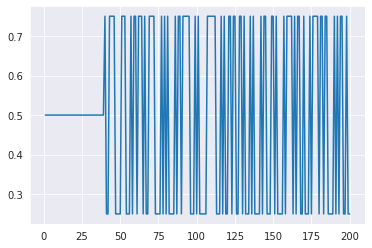

In [86]:
accuracies_ = accuracies[:2000:10]
plt.plot(np.arange(1, len(accuracies_)+1), accuracies_)

## Task 2

## Task 3